# <center>Bangkok Haunts Clustered</center>
## <center>Nicholas Tantra</center>

## <center>May 8, 2021</center>



# Introduction

## Background

Bangkok is one of the biggest cities in Asia - with over 10 Million inhabitants and over 1.5 Million square kilometers of land. The city is also home to the best restaurants and nightlife venues in the world and coupled with one of the more well developed transit systems in South East Asia - it is a truly thrumming metropolis.

So what now? How would one navigate the districts of Bangkok - in which there are 50-odd ones or if you want to be more specific - over 170 subdistricts with their own little quirky characteristics.

## Problem

The data obtained from wikipedia provides the baseline information on the districts and subdistricts of Bangkok - as well as the coordinate information for the Districts. While the HERE API provides us with the coordinates of the Sub-districts of Bangkok.

While the data obtained using the Foursquare explore API can give a rough approximation of the types of venues present in each districts.  

With both sets of data should be able to create a rudimentary clustering of districts and subdistricts according to their venue tendencies.


## Interest

The ability to roughly cluster districts and subdistricts would be useful to visitors to the city as the cluster information would be able to identify the rough makeups of a certain district and like for like districts that should be part of the search criteria.


# Data Acquisition and Cleaning

## Data Sources

This notebook will use the Wikipedia page on Bangkok District and Subdistricts.  

*   https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok
*   https://en.wikipedia.org/wiki/Khwaeng

The coordinate information for the Districts are available through Wikipedia.  The Subdistricts coordinates will be acquired via HERE's API (will be imported in via CSV for ease of access) (https://developer.here.com/develop/rest-apis)

The venues information will be acquired by using FourSquare's Explore API. (https://developer.foursquare.com/)

## Data Cleaning

The district and subdistrict data were scraped from Wikipedia and then combined to create a unified dataframe with the district and subdistrict information.  Then performed the HERE API calls to obtain the coordinate information for the subdistricts and then continue to merge the data to form the subdistrict information dataframe.

With the full list of district and subdistrict - we can proceed to obtain the venue data related to the districts and subdistricts using the FourSquare API.  The Venue data are then transformed down into its own districts and subdistricts - and with the relevant combinations of venue categories.  Venue categories that are few and far inbetween are then combined to form a bigger group of venue categories.  Following the categorical mapping - the venue data are then extracted to form one-hot-encoded dataframes.  

The one-hot-encoded dataframes are then aggregated on a category and district/subdistrict level to form the base for the clusters.


## Feature Selection

After cleaning - we narrowed down the venue category mapping to cluster most like for like categories into one overarching category (for instance the Japanese Restaurants) and merge venue categories will less than 20 entries to reduce the dimension of the one-hot-encodings.

```python
japanese_restaurants = ['Donburi Restaurant', 'Ramen Restaurant', \
                        'Tonkatsu Restaurant', 'Udon Restaurant', 'Sake Bar', \
                        'Sushi Restaurant', 'Shabu-Shabu Restaurant', \
                        'Japanese Curry Restaurant', 'Yakitori Restaurant', \
                        'Monjayaki Restaurant', 'Yoshoku Restaurant', 'Kushikatsu Restaurant']
```



# Exploratory Data Analysis

## Exploring District level Venue Concentrations

Following the data cleaning process we can visualise the concentration of venues around Bangkok.

In [49]:
map_bangkok

As expected the largest concentrations of venues are in the center of the city - with some pockets venues in the south-west and directly due to the east.  

Using the one-hot-encoded venue details and the cluster labels we can generate the district level clusters.

## Exploring Subdistrict level Venue Concentrations

Similar to the District level visualisation - we can also visualise the subdistrict based venue concentration.

# Clustering

## Clustering Bangkok Districts by Venue

Performing the clustering algorithm using the one-hot-encoded event data to construct the clusters.  In this case we used 6 clusters to categorise the districts of Bangkok.

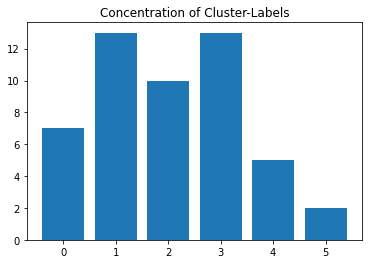

In [53]:
# Concentration of labels
d_labels, d_counts = np.unique(district_kmeans.labels_, return_counts=True)
plt.bar(d_labels, d_counts, align='center')
plt.title("Concentration of Cluster-Labels")
plt.gca().set_xticks(d_labels)
plt.show()

## Visualising the District based clustering

When visualised on the map we can see the concentrations of venues based on the districts.

The six clusters can be seen across Bangkok.  

In [91]:
district_venue_clusters

## Clustering Bangkok Subdistricts by Venue

Similar to the district level clustering but this time at the sub-district level.  We can see here that there are three distinct clusters within the city.  

In [92]:
subdistrict_venue_clusters

## Clustering to Bangkok Subdistrict with reduced Categories

By reducing the number of categories used - we can see if the clusters can be improved.  Below is the map visualisation with 7 category types.

In [149]:
subdistrict_reduced_venue_clusters

# Conclusion

By examining the clusters formed during the process we can see that some notable clusters have been formed around certain areas of Bangkok in-line with what one would expect when viewing the tourist's guide to Bangkok.  

By examining the three clustered visualisation - we can see that the Subdistrict level clustering are a fair bit more accurate or more finely clustered - offering a much more precise insight into the neighborhoods associated.

Upon closer examination - the reduced category clustering seems to also result in a similar cluster to the Subdirectory clustering.  Although based on the result - the clusters are not as well defined and seem to have lost a lot of details - no doubt this is due to the aggressive culling down of categories.  

# Future Directions

Following the results of these findings, we can assume that the anomalies or irregularities in the venue clustering are caused my the irregularly shaped district and subdistrict boundaries.  Hence - it would be a great idea to move away from the District-Subdistrict clustering and focus on a interval-coordinate based system.  

# Appendix

## Code

### Library Includes

In [ ]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import urllib.parse
import time

print('Libraries imported.')

Libraries imported.


In [ ]:
CLIENT_ID = ''        # Foursquare ID
CLIENT_SECRET = ''    # Foursquare Secret
VERSION = '20180605'  # Foursquare API version
LIMIT = 100           # A default Foursquare API limit value

In [111]:
# FourSquare API call 
# Retrieve venues around specified latitude and longitude location
# Returns DF of result
def getNearbyVenues(names, latitudes, longitudes, radius=500, print_progress=True):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        if print_progress:
          print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# Return the categories of most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

# Combines certain venue categories based on mapping
def combine_venue_categories(df, mapping):
  for label, listing in mapping.items():
    df["Venue Category"] = df["Venue Category"].apply(lambda x: label if x in listing else x)
  return df

#Runs KMeans clustering
def run_clustering(df, cluster_count, random_state=None, target='District'):

    df_cip = df.drop(target, 1)
    kmeans = KMeans(n_clusters=cluster_count, random_state=random_state).fit(df_cip)

    labels, counts = np.unique(kmeans.labels_, return_counts=True)
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.show()
    
    return kmeans

# Extracts the top venue categories per region
def venue_extraction(df, num_top_venues = 10, labl = 'District'):
  indicators = ['st', 'nd', 'rd']

  # create columns according to number of top venues
  columns = [labl]
  for ind in np.arange(num_top_venues):
      try:
          columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
      except:
          columns.append('{}th Most Common Venue'.format(ind+1))

  # create a new dataframe
  area_venues_sorted = pd.DataFrame(columns=columns)
  area_venues_sorted[labl] = df[labl]

  for ind in np.arange(df.shape[0]):
      area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df.iloc[ind, :], num_top_venues)

  area_venues_sorted.head()
  return area_venues_sorted

# Prints out the clustered results
def show_clusters(df, clusters, limit=10):
  for cluster in range(clusters):
    print("\n\n\nCluster " + str(cluster + 1) + " out of " + str(clusters) + "\n\n")
    display(df.loc[df['Cluster Labels'] == cluster, df.columns[[0] + list(range(limit, df.shape[1]))]])

In [ ]:
# Venue Category Merge - Mapping
japanese_restaurants = ['Donburi Restaurant', 'Ramen Restaurant', \
                        'Tonkatsu Restaurant', 'Udon Restaurant', 'Sake Bar', \
                        'Sushi Restaurant', 'Shabu-Shabu Restaurant', \
                        'Japanese Curry Restaurant', 'Yakitori Restaurant', \
                        'Monjayaki Restaurant', 'Yoshoku Restaurant', 'Kushikatsu Restaurant']

asian_restaurant = ['Korean Restaurant', 'Tea Room', 'Vietnamese Restaurant', \
                    'Halal Restaurant', 'Satay Restaurant', 'Malay Restaurant', \
                    'Middle Eastern Restaurant', 'Sri Lankan Restaurant', 'Indian Restaurant']

chinese_restaurant = ['Dim Sum Restaurant', 'Cantonese Restaurant', \
                      'Dumpling Restaurant', 'Szechuan Restaurant',
                      'Taiwanese Restaurant', 'Hainan Restaurant', 'Shanghai Restaurant']

accomodations = ['Hostel', 'Bed & Breakfast', 'Hotel', 'Hotel Pool', \
                 'Residential Building (Apartment / Condo)', 'Resort', 'Motel', \
                 'Boarding House']

western_restaurant = ['American Restaurant', 'German Restaurant', \
                      'Brewery', 'Bistro', 'Pizza Place', 'Steakhouse', \
                      'Breakfast Spot', 'Fried Chicken Joint', \
                      'Mexican Restaurant', 'Spanish Restaurant ', \
                      'Mediterranean Restaurant', 'Wings Joint', 'Burger Joint', \
                      'Italian Restaurant', 'Fast Food Restaurant', \
                      'Eastern European Restaurant', 'Spanish Restaurant', \
                      'French Restaurant', 'Turkish Restaurant', 'Gastropub', \
                      'New American Restaurant', 'Israeli Restaurant', \
                      'Fish & Chips Shop', 'Sandwich Place', 'Deli / Bodega']

nightlife = ['Nightclub', 'Gay Bar', 'Speakeasy', 'Karaoke Bar', 'Jazz Club', \
             'Cocktail Bar', 'Hotel Bar', 'Lounge', 'Wine Bar', \
             'Other Nightlife', 'Beer Bar', 'Massage Studio', 'Spa', 'Bar', \
             'Bath House', 'Irish Pub', 'Beer Garden', 'Whisky Bar', \
             'Wine Shop', 'Pub', 'Night Market', 'Dive Bar']

restaurants = ['Food', 'Diner', 'Snack Place', 'Salad Place', \
               'Comfort Food Restaurant', 'Soup Place', 'Food Court', \
               'Food & Drink Shop', 'Vegetarian / Vegan Restaurant', 'Cafeteria', \
               'Buffet', 'Food Truck', 'Som Tum Restaurant', 'Thai Restaurant', \
               'Food Stand', 'Food Service']

household = ['Organic Grocery', 'Floating Market', 'Auto Garage', 'Laundromat', \
             'Pharmacy', 'Medical Center', 'Health & Beauty Service', \
             'Veterinarian', 'Grocery Store', 'Supermarket', 'Farmers Market', \
             'Grocery', 'Market', 'Flea Market', 'Bakery', 'Bank', 'Butcher', \
             'Salon / Barbershop', 'Dentist\'s Office', 'Nail Salon']

stores = ['Dive Shop', 'Bridal Shop', 'Antique Shop', 'Bike Shop', 'Flower Shop', \
          'Motorcycle Shop', 'Jewelry Store', 'Boutique', 'Shop & Service', \
          'Arts & Crafts Store', 'Hobby Shop', 'Miscellaneous Shop', \
          'Comic Shop', 'Thrift / Vintage Store', 'Herbs & Spices Store', \
          'Men\'s Store', 'Sausage Shop', 'Accessories Store', \
          'Sporting Goods Shop', 'Gourmet Shop', 'Clothing Store', \
          'Cosmetics Shop', 'Mobile Phone Shop', 'Department Store', \
          'Outdoor Supply Store', 'Shoe Store', 'Automotive Shop', \
          'Furniture / Home Store', 'Pet Store', 'Discount Store', 'Video Store', \
          'Electronics Store', 'Big Box Store']

culture = ['Monument / Landmark', 'History Museum', 'Neighborhood', 'Museum', \
           'Historic Site', 'Art Gallery', 'Theater', 'Tour Provider', \
           'Gift Shop', 'Zoo', 'Outdoor Sculpture', 'Concert Hall', \
           'Science Museum', 'Sculpture Garden', 'Performing Arts Venue', \
           'Palace', 'Shrine', 'Buddhist Temple', 'Art Museum', 'Spiritual Center']

activities = ['Movie Theater', 'Garden Center', 'Stadium', 'Park', \
              'Garden', 'Harbor / Marina', 'Bookstore', 'Soccer Stadium', \
              'Music Venue', 'Multiplex', 'Playground', 'Recreation Center', \
              'Bike Rental / Bike Share', 'Dog Run', 'Roof Deck', \
              'Lake', 'Escape Room', 'Theme Park Ride / Attraction', \
              'Cooking School', 'Farm', 'Vineyard', 'Scenic Lookout']

sport = ['Skate Park', 'Golf Driving Range', 'Soccer Field', 'Boxing Gym', \
         'Bowling Alley', 'Sports Club', 'Gym', 'Badminton Court', 'Pool', \
         'Gym / Fitness Center', 'College Gym', 'College Quad', 'Track', \
         'Baseball Field', 'Mini Golf', 'Gun Range', 'Basketball Court', \
         'Tennis Court', 'Squash Court', 'Golf Course', 'Gym Pool', \
         'Athletics & Sports', 'Yoga Studio', 'Dance Studio', 'Skating Rink', \
         'Climbing Gym']

commercial = ['Recording Studio', 'Coworking Space', 'Paper / Office Supplies Store', \
              'Photography Studio', 'Duty-free Shop', 'Other Repair Shop', \
              'Factory', 'Film Studio', 'Auto Workshop', \
              'Auto Dealership', 'Construction & Landscaping', \
              'Office']

infrastructure = ['Train Station', 'Canal', 'Pier', 'Bus Line', 'Building', \
                  'Shopping Mall', 'Pedestrian Plaza', 'Bus Stop', \
                  'Intersection', 'Rest Area', 'Cruise Ship', 'Road', \
                  'Government Building', 'Airport', 'Gas Station', \
                  'Airport Service', 'Airport Lounge', 'Airport Food Court', \
                  'Bus Station', 'River', 'Boat or Ferry', 'Shopping Plaza', 'Library', 'Plaza']

cafe = ['Gaming Cafe', 'Coffee Shop', 'Pet Café']

dessert_shop = ['Bubble Tea Shop', 'Frozen Yogurt Shop', 'Juice Bar', 'Pastry Shop', \
                'Ice Cream Shop', 'Donut Shop', 'Chocolate Shop', 'Creperie', \
                'Dessert Shop', 'Smoothie Shop']

mapping = {'Japanese Restaurant': japanese_restaurants,
           'Asian Restaurant': asian_restaurant,
           'Chinese Restaurant': chinese_restaurant,
           'Accomodation': accomodations, 
           'Western Restaurant': western_restaurant,
           'Nightlife': nightlife,
           'Restaurant': restaurants,
           'Household': household,
           'Culture': culture,
           'Activities': activities,
           'Infrastructure': infrastructure,
           'Commercial': commercial,
           'Café': cafe,
           'Sport': sport,
           'Dessert Shop': dessert_shop,
           'Stores': stores }

In [ ]:
# Getting Bangkok's coordinates
address = 'Bangkok'

geolocator = Nominatim(user_agent="bkk_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok are 13.7544238, 100.4930399.


In [ ]:
# Scraping Wikipedia for a list of Bangkok Districts
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok'

df = pd.read_html(url)[0]
html_doc = requests.get(url)
soup = BeautifulSoup(html_doc.text, 'html.parser')

table_contents = []
table = soup.find('table')

for row in table.findAll('tr'):
  cell = {}

  for cnt, text in enumerate(row.findAll('td')):
    if cnt == 0:
      cell['District'] = text.get_text()
    elif cnt == 1:
      cell['Map Number'] = text.get_text()
    elif cnt == 2:
      cell['Postcode'] = text.get_text()
    elif cnt == 3:
      cell['Thai'] = text.get_text()
    elif cnt == 4:
      cell['Population'] = text.get_text()
    elif cnt == 5:
      cell['Subdistrict Count'] = text.get_text()
    elif cnt == 6:
      cell['Latitude'] = text.get_text()
    elif cnt == 7:
      cell['Longitude'] = text.get_text()
      
  if len(cell) != 0:
    table_contents.append(cell)

bkk_districts_wk = pd.DataFrame(table_contents)

bkk_districts_wk['Postcode'] = bkk_districts_wk['Postcode'].str.replace(r'\n', '')
bkk_districts_wk['Population'] = bkk_districts_wk['Population'].str.replace(r',', '')
bkk_districts_wk['Subdistrict Count'] = bkk_districts_wk['Subdistrict Count'].str.replace(r'\n', '')
bkk_districts_wk['Latitude'] = bkk_districts_wk['Latitude'].str.replace(r'\n', '')
bkk_districts_wk['Longitude'] = bkk_districts_wk['Longitude'].str.replace(r'\n', '')
bkk_districts_wk[["Map Number", "Postcode", "Population", "Subdistrict Count", "Latitude", \
    "Longitude"]] = bkk_districts_wk[["Map Number", "Postcode", "Population", \
    "Subdistrict Count", "Latitude", "Longitude"]].apply(pd.to_numeric)
df.head(3)

,District(Khet),MapNr,Post-code,Thai,Popu-lation,No. ofSubdis-trictsKhwaeng,Latitude,Longitude
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444


In [ ]:
# Tracking the number of categories present from the Foursquare results
bkk_venues = getNearbyVenues(bkk_districts_wk['District'], bkk_districts_wk['Latitude'], bkk_districts_wk['Longitude'], print_progress=False)

In [ ]:
bkk_venues.to_csv(r'BKK_Venues.csv', header=True)
print('There are {} unique categories.'.format(len(bkk_venues['Venue Category'].unique())))

There are 165 unique categories.


In [ ]:
# Count and combine the number of Venues
bkk_venue_count = bkk_venues.groupby('District').count()['Venue'].to_frame()
df_bkk = bkk_districts_wk.merge(bkk_venue_count, left_on='District', right_on='District')
df_bkk.rename(columns={'Venue':'Venue Count'}, inplace=True)
df_bkk['Venue Count'] = ( df_bkk['Venue Count'] - df_bkk['Venue Count'].mean()) / df_bkk['Venue Count'].std() # Normalise the number of venues

df_bkk.head(3)

,District,Map Number,Postcode,Thai,Population,Subdistrict Count,Latitude,Longitude,Venue Count
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,-0.827297
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,-0.225428
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,-0.663151


In [ ]:
# Plot the map for districts of bangkok based on venue count
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Toner")

for lat, lng, label, count in zip(df_bkk['Latitude'], df_bkk['Longitude'], df_bkk['District'], df_bkk['Venue Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= (10 + 5 * count),
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_bangkok)  
map_bangkok

In [ ]:
# Combine the venue categories according to the mapping
bkk_venues_condensed = combine_venue_categories(bkk_venues, mapping)
district_venue_category = bkk_venues_condensed.groupby('Venue Category').count()['Venue']
district_venue_category = district_venue_category.sort_values(ascending=False)
district_venue_category.head(10)

Venue Category
Restaurant             144
Café                   134
Noodle House           123
Convenience Store       77
Western Restaurant      71
Asian Restaurant        65
Household               64
Japanese Restaurant     62
Nightlife               59
Accomodation            46
Name: Venue, dtype: int64

In [ ]:
# Performing One-Hot encoding to explore venue categories
bkk_onehot = pd.get_dummies(bkk_venues_condensed[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
bkk_onehot['District'] = bkk_venues_condensed['District']
# move neighborhood column to the first column
fixed_columns = [bkk_onehot.columns[-1]] + list(bkk_onehot.columns[:-1])
bkk_onehot = bkk_onehot[fixed_columns]

bkk_onehot.head(3)

,District,Accomodation,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint,Café,Chinese Restaurant,Commercial,Convenience Store,Culture,Dessert Shop,Hotpot Restaurant,Household,Infrastructure,Japanese Restaurant,Kids Store,Nightlife,Noodle House,Restaurant,Seafood Restaurant,Sport,Stores,Toll Plaza,Western Restaurant,Women's Store
0,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,Bang Bon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,Bang Bon,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(str(bkk_onehot.shape[0]) + " Venues, " + str(bkk_onehot.shape[1]) + " Categories")
bkk_grouped = bkk_onehot.groupby('District').mean().reset_index()
print(str(bkk_grouped.shape[0]) + " Districts")

1156 Venues, 26 Categories
50 Districts


In [ ]:
# Extract the most popular venues by District
district_venues_sorted = venue_extraction(bkk_grouped)
district_venues_sorted.head(3)

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Restaurant,Infrastructure,Household,Asian Restaurant,Japanese Restaurant,Convenience Store,Dessert Shop,Activities,Arts & Entertainment,BBQ Joint
1,Bang Kapi,Noodle House,Japanese Restaurant,Household,Culture,Convenience Store,Activities,BBQ Joint,Restaurant,Nightlife,Café
2,Bang Khae,Café,Noodle House,Convenience Store,Household,Asian Restaurant,Japanese Restaurant,Infrastructure,Western Restaurant,Culture,Activities


# Clustering Bangkok

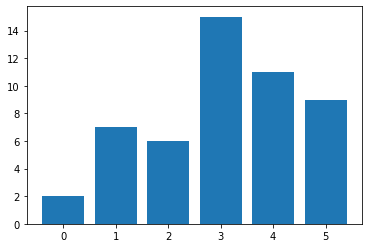

In [68]:
# Run KMeans clustering
bkk_cluster_cnt = 6
district_kmeans = run_clustering(bkk_grouped, bkk_cluster_cnt, random_state=42)

In [69]:
# add clustering labels
if 'Cluster Labels' in district_venues_sorted.columns:
  district_venues_sorted = district_venues_sorted.drop('Cluster Labels', axis=1)

district_venues_sorted.insert(0, 'Cluster Labels', district_kmeans.labels_)

district_clusters = df_bkk
# merge bkk_grouped with bkk data (df) to add latitude/longitude for each neighborhood
district_clusters = district_clusters.join(district_venues_sorted.set_index('District'), on='District')
district_clusters['Cluster Labels'] = district_clusters['Cluster Labels'].replace(np.nan, -1)
district_clusters['Cluster Labels'] = district_clusters['Cluster Labels'].astype(int)
district_clusters.head()

,District,Map Number,Postcode,Thai,Population,Subdistrict Count,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,50,10150,บางบอน,105161,4,13.659200,100.399100,-0.827297,2,Restaurant,Infrastructure,Household,Asian Restaurant,Japanese Restaurant,Convenience Store,Dessert Shop,Activities,Arts & Entertainment,BBQ Joint
1,Bang Kapi,6,10240,บางกะปิ,148465,2,13.765833,100.647778,-0.225428,3,Noodle House,Japanese Restaurant,Household,Culture,Convenience Store,Activities,BBQ Joint,Restaurant,Nightlife,Café
2,Bang Khae,40,10160,บางแค,191781,4,13.696111,100.409444,-0.663151,3,Café,Noodle House,Convenience Store,Household,Asian Restaurant,Japanese Restaurant,Infrastructure,Western Restaurant,Culture,Activities
3,Bang Khen,5,10220,บางเขน,189539,2,13.873889,100.596389,-0.499005,3,Asian Restaurant,Activities,Café,Convenience Store,Accomodation,Sport,Restaurant,Noodle House,Infrastructure,Culture
4,Bang Kho Laem,31,10120,บางคอแหลม,94956,3,13.693333,100.502500,-0.389574,4,Restaurant,Noodle House,Café,Chinese Restaurant,Household,Asian Restaurant,Infrastructure,Western Restaurant,Hotpot Restaurant,Convenience Store


In [70]:
# create map
district_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=12, tiles="Stamen Toner")

# set color scheme for the clusters
x = np.arange(bkk_cluster_cnt)
ys = [i + x + (i*x)**2 for i in range(bkk_cluster_cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(district_clusters['Latitude'], 
                                         district_clusters['Longitude'], 
                                         district_clusters['District'], 
                                         district_clusters['Cluster Labels'], 
                                         district_clusters['Venue Count']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        popup=label,
        color=rainbow[cluster-1],
        radius= (10 + 5 * count),
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(district_venue_clusters)
       
district_venue_clusters

In [71]:
show_clusters(district_clusters, bkk_cluster_cnt)




Cluster 1 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Khlong Toei,Nightlife,Restaurant,Infrastructure,Commercial,Women's Store,Dessert Shop,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint
38,Sai Mai,Nightlife,Restaurant,Noodle House,Western Restaurant,Women's Store,Culture,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint





Cluster 2 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Bang Khun Thian,Japanese Restaurant,Restaurant,Stores,Sport,Dessert Shop,Western Restaurant,Household,Activities,Infrastructure,Café
14,Chom Thong,Western Restaurant,Dessert Shop,Toll Plaza,Restaurant,Café,Women's Store,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint
19,Khan Na Yao,Japanese Restaurant,Restaurant,Western Restaurant,Dessert Shop,Café,Household,Nightlife,BBQ Joint,Activities,Noodle House
23,Lak Si,Western Restaurant,Café,Restaurant,Infrastructure,Household,Japanese Restaurant,Activities,Convenience Store,Dessert Shop,Hotpot Restaurant
30,Phasi Charoen,Western Restaurant,Japanese Restaurant,Stores,Café,Hotpot Restaurant,BBQ Joint,Activities,Restaurant,Convenience Store,Seafood Restaurant
32,Phra Khanong,Convenience Store,Western Restaurant,Accomodation,Dessert Shop,Nightlife,Café,Infrastructure,Japanese Restaurant,Household,Sport
49,Yan Nawa,Convenience Store,Western Restaurant,Café,Restaurant,Chinese Restaurant,Japanese Restaurant,Household,Asian Restaurant,Sport,Stores





Cluster 3 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Bon,Restaurant,Infrastructure,Household,Asian Restaurant,Japanese Restaurant,Convenience Store,Dessert Shop,Activities,Arts & Entertainment,BBQ Joint
16,Don Mueang,Restaurant,Household,Convenience Store,BBQ Joint,Café,Western Restaurant,Accomodation,Noodle House,Nightlife,Activities
20,Khlong Sam Wa,Restaurant,Café,Nightlife,Chinese Restaurant,Japanese Restaurant,Convenience Store,Women's Store,Dessert Shop,Activities,Arts & Entertainment
27,Nong Chok,Dessert Shop,Restaurant,Household,Activities,Asian Restaurant,Convenience Store,Infrastructure,Arts & Entertainment,BBQ Joint,Café
36,Rat Burana,Restaurant,Activities,Stores,Sport,Noodle House,Asian Restaurant,Western Restaurant,Hotpot Restaurant,Women's Store,Convenience Store
40,Saphan Sung,Restaurant,Activities,Japanese Restaurant,Convenience Store,Women's Store,Dessert Shop,Arts & Entertainment,Asian Restaurant,BBQ Joint,Café





Cluster 4 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Bang Kapi,Noodle House,Japanese Restaurant,Household,Culture,Convenience Store,Activities,BBQ Joint,Restaurant,Nightlife,Café
2,Bang Khae,Café,Noodle House,Convenience Store,Household,Asian Restaurant,Japanese Restaurant,Infrastructure,Western Restaurant,Culture,Activities
3,Bang Khen,Asian Restaurant,Activities,Café,Convenience Store,Accomodation,Sport,Restaurant,Noodle House,Infrastructure,Culture
7,Bang Phlat,Noodle House,Café,Convenience Store,Household,Activities,Restaurant,Nightlife,Infrastructure,Western Restaurant,Culture
12,Bueng Kum,Household,Stores,Activities,Asian Restaurant,Convenience Store,Hotpot Restaurant,Arts & Entertainment,BBQ Joint,Café,Chinese Restaurant
15,Din Daeng,Activities,Sport,Restaurant,Convenience Store,Accomodation,Stores,Culture,Dessert Shop,Arts & Entertainment,Asian Restaurant
25,Lat Phrao,Café,Noodle House,Household,Restaurant,Asian Restaurant,Convenience Store,Sport,BBQ Joint,Japanese Restaurant,Chinese Restaurant
29,Pathum Wan,Asian Restaurant,Restaurant,Convenience Store,Noodle House,Dessert Shop,Chinese Restaurant,Seafood Restaurant,Japanese Restaurant,Café,Stores
34,Pom Prap Sattru Phai,Noodle House,Café,Chinese Restaurant,Western Restaurant,Convenience Store,Restaurant,Culture,Dessert Shop,Asian Restaurant,Infrastructure
35,Prawet,Convenience Store,Asian Restaurant,Restaurant,Noodle House,Women's Store,Dessert Shop,Activities,Arts & Entertainment,BBQ Joint,Café





Cluster 5 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Bang Kho Laem,Restaurant,Noodle House,Café,Chinese Restaurant,Household,Asian Restaurant,Infrastructure,Western Restaurant,Hotpot Restaurant,Convenience Store
6,Bang Na,Asian Restaurant,Noodle House,Seafood Restaurant,Restaurant,Café,Chinese Restaurant,Women's Store,Dessert Shop,Activities,Arts & Entertainment
8,Bang Rak,Noodle House,Accomodation,Chinese Restaurant,Restaurant,Nightlife,Café,Western Restaurant,Household,Seafood Restaurant,Commercial
9,Bang Sue,Restaurant,Noodle House,Café,Convenience Store,Activities,Sport,Seafood Restaurant,Nightlife,Hotpot Restaurant,Women's Store
10,Bangkok Noi,Noodle House,Café,Restaurant,Western Restaurant,Dessert Shop,Activities,Asian Restaurant,Chinese Restaurant,Convenience Store,Women's Store
11,Bangkok Yai,Noodle House,Restaurant,Household,Asian Restaurant,Café,Chinese Restaurant,Dessert Shop,Seafood Restaurant,BBQ Joint,Infrastructure
17,Dusit,Noodle House,Convenience Store,Asian Restaurant,Household,Dessert Shop,Sport,Restaurant,Café,Activities,Arts & Entertainment
18,Huai Khwang,Restaurant,Noodle House,Accomodation,Convenience Store,Hotpot Restaurant,Asian Restaurant,BBQ Joint,Chinese Restaurant,Household,Stores
24,Lat Krabang,Restaurant,Noodle House,Accomodation,Asian Restaurant,Dessert Shop,Activities,Arts & Entertainment,BBQ Joint,Café,Chinese Restaurant
42,Suan Luang,Noodle House,Restaurant,Café,Asian Restaurant,Household,Convenience Store,Sport,Stores,Western Restaurant,Nightlife





Cluster 6 out of 6




,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Chatuchak,Café,Household,Restaurant,Nightlife,Accomodation,Sport,Noodle House,Activities,Asian Restaurant,Western Restaurant
21,Khlong San,Café,Restaurant,Culture,Dessert Shop,Activities,Stores,Nightlife,Chinese Restaurant,Accomodation,Noodle House
26,Min Buri,Stores,Restaurant,Café,Infrastructure,Women's Store,Dessert Shop,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint
28,Nong Khaem,Restaurant,Café,Household,Dessert Shop,Stores,Noodle House,Activities,Arts & Entertainment,Asian Restaurant,BBQ Joint
31,Phaya Thai,Restaurant,Café,Japanese Restaurant,Nightlife,Western Restaurant,Household,Asian Restaurant,Dessert Shop,Infrastructure,Activities
33,Phra Nakhon,Accomodation,Nightlife,Asian Restaurant,Restaurant,Café,Culture,Activities,Household,Noodle House,Japanese Restaurant
37,Ratchathewi,Restaurant,Café,Accomodation,Nightlife,Sport,Noodle House,Asian Restaurant,Western Restaurant,Culture,Convenience Store
39,Samphanthawong,Culture,Café,Nightlife,Accomodation,Chinese Restaurant,Restaurant,Activities,Seafood Restaurant,Noodle House,Japanese Restaurant
48,Watthana,Café,Household,Nightlife,Japanese Restaurant,Convenience Store,Infrastructure,BBQ Joint,Chinese Restaurant,Culture,Accomodation


# Getting the list of Subdistricts for Bangkok

In [72]:
# Scrape wikipedia for the list of Subdistricts in Bangkok
url2 = 'https://en.wikipedia.org/wiki/Khwaeng'
bkk_subdistrict_wk = pd.read_html(url2, skiprows=1, header=1)
bkk_subdistrict_wk = bkk_subdistrict_wk[0]
bkk_subdistrict_wk.columns = ['Map Number', 'District', 'District (Thai)', 'Subdistrict Number', 'Subdistrict', 'Subdistrict (Thai)', 'isSeat']
bkk_subdistrict_wk[['Map Number', 'Subdistrict Number']] =  bkk_subdistrict_wk[['Map Number', 'Subdistrict Number']].apply(pd.to_numeric)
bkk_subdistrict_wk['isSeat'] = bkk_subdistrict_wk['isSeat'].apply(lambda x : 0 if pd.isnull(x) else 1)
bkk_subdistrict_wk.head()

,Map Number,District,District (Thai),Subdistrict Number,Subdistrict,Subdistrict (Thai),isSeat
0,1,Phra Nakhon,พระนคร,1,Phra Borom Maha Ratchawang,พระบรมมหาราชวัง,0
1,1,Phra Nakhon,พระนคร,2,Wang Burapha Phirom,วังบูรพาภิรมย์,0
2,1,Phra Nakhon,พระนคร,3,Wat Ratchabophit,วัดราชบพิธ,0
3,1,Phra Nakhon,พระนคร,4,Samran Rat,สำราญราษฎร์,0
4,1,Phra Nakhon,พระนคร,5,San Chaopho Suea,ศาลเจ้าพ่อเสือ,0


# Getting BKK's Subdistrict Coordinates using HERE API

In [73]:
# Load Subdistrict Coordinate information from CSV (obtained using HERE API)
subdistrict_coords = pd.read_csv('BKK_Subdistricts.csv', index_col=0)
subdistrict_coords.head()

,District,Subdistrict,Latitude,Longitude
0,Phra Nakhon,Phra Borom Maha Ratchawang,13.75532,100.49498
1,Phra Nakhon,Wang Burapha Phirom,13.74512,100.49935
2,Phra Nakhon,Wat Ratchabophit,13.75047,100.50029
3,Phra Nakhon,Samran Rat,13.75204,100.50449
4,Phra Nakhon,San Chaopho Suea,13.75467,100.49684


In [74]:
# Merge subdistrict detail with subdistrict coordinates
bkk_subdistricts = bkk_subdistrict_wk.merge(subdistrict_coords, how='left', on=('District', 'Subdistrict')).drop('Map Number', axis=1)
bkk_subdistricts['Subdistrict'] = bkk_subdistricts['Subdistrict'] + ', ' + bkk_subdistricts['District']
bkk_subdistricts = bkk_subdistricts.drop(columns=['District', 'District (Thai)', 'Subdistrict Number', 'Subdistrict (Thai)'], axis=1)
print(bkk_subdistricts.shape)
bkk_subdistricts.head()

(180, 4)


,Subdistrict,isSeat,Latitude,Longitude
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029
3,"Samran Rat, Phra Nakhon",0,13.75204,100.50449
4,"San Chaopho Suea, Phra Nakhon",0,13.75467,100.49684


In [75]:
# Call Foursquare API to extract venue lists by subdistrict coordinates
bkk_sub_venues = getNearbyVenues(bkk_subdistricts['Subdistrict'], bkk_subdistricts['Latitude'], bkk_subdistricts['Longitude'], print_progress=False)

In [76]:
bkk_sub_venues.to_csv(r'BKK_Subdistrict_Venues.csv', header=True)

In [77]:
print('There are {} unique categories.'.format(len(bkk_sub_venues['Venue Category'].unique())))

bkk_sub_venues.rename(columns={'District':'Subdistrict', 'District Latitude': 'Latitude', 'District Longitude': 'Longitude'}, inplace=True)
bkk_sub_venues.head(3)

There are 259 unique categories.


,Subdistrict,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,Thokkathan-Mother Earth Squeezing Her Hair (พร...,13.756602,100.494767,Spiritual Center
1,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,Siwamokhaphiman Hall (พระที่นั่งศิวโมกขพิมาน),13.757516,100.492140,Museum
2,"Phra Borom Maha Ratchawang, Phra Nakhon",13.75532,100.49498,พระที่นั่งพุทไธสวรรย์,13.757895,100.492100,History Museum


In [78]:
bkk_sub_venues['Subdistrict'].nunique()

176

In [79]:
# Count the number of venues by subdistrict
bkk_sub_venue_count = bkk_sub_venues.groupby('Subdistrict').count()['Venue'].to_frame()
df_bkk_sub = bkk_subdistricts.merge(bkk_sub_venue_count, left_on='Subdistrict', right_on='Subdistrict')
df_bkk_sub.rename(columns={'Venue':'Venue Count'}, inplace=True)

# Normalise the venue count
df_bkk_sub['Venue Count'] = ( df_bkk_sub['Venue Count'] - df_bkk_sub['Venue Count'].mean()) / df_bkk_sub['Venue Count'].std()

df_bkk_sub.head(3)

,Subdistrict,isSeat,Latitude,Longitude,Venue Count
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498,2.234317
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935,0.777199
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029,1.141478


In [80]:
# Plot the subdistricts and their venue counts
map_bangkok_subdistricts = folium.Map(location=[latitude, longitude], zoom_start=13, tiles="Stamen Toner")

for lat, lng, label, count in zip(df_bkk_sub['Latitude'], df_bkk_sub['Longitude'], df_bkk_sub['Subdistrict'], df_bkk_sub['Venue Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius= (5 + 4 * count),
        popup=label,
        color='#3186cc',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_bangkok_subdistricts)  

map_bangkok_subdistricts

In [81]:
# Combine the Subdistrict's venue categories based on the mapping
bkk_sub_venues_condensed = combine_venue_categories(bkk_sub_venues, mapping)
subdistrict_venue_category = bkk_sub_venues_condensed.groupby('Venue Category').count()['Venue']
subdistrict_venue_category = subdistrict_venue_category.sort_values(ascending=False)
subdistrict_venue_category.head(20)

Venue Category
Restaurant             538
Café                   425
Noodle House           358
Nightlife              318
Convenience Store      263
Western Restaurant     230
Asian Restaurant       227
Accomodation           211
Household              196
Japanese Restaurant    143
Dessert Shop           142
Chinese Restaurant     142
Sport                  119
Culture                109
Infrastructure         107
Stores                  90
Activities              68
Seafood Restaurant      63
BBQ Joint               46
Hotpot Restaurant       35
Name: Venue, dtype: int64

In [82]:
bkk_sub_onehot = pd.get_dummies(bkk_sub_venues_condensed[['Venue Category']], prefix="", prefix_sep="")

# adding neighborhood column back to dataframe
bkk_sub_onehot['Subdistrict'] = bkk_sub_venues_condensed['Subdistrict']
# move neighborhood column to the first column
fixed_columns = [bkk_sub_onehot.columns[-1]] + list(bkk_sub_onehot.columns[:-1])
bkk_sub_onehot = bkk_sub_onehot[fixed_columns]

bkk_sub_onehot.head(3)

,Subdistrict,Accomodation,Activities,Asian Restaurant,BBQ Joint,Café,Chinese Restaurant,Commercial,Convenience Store,Culture,Currency Exchange,Dessert Shop,Football Stadium,Hotpot Restaurant,Household,Infrastructure,Japanese Restaurant,Kebab Restaurant,Kids Store,Leather Goods Store,Music School,Music Store,Nightlife,Noodle House,Outlet Store,Print Shop,Restaurant,Rooftop Bar,Seafood Restaurant,Sport,Stores,Tailor Shop,Tourist Information Center,Toy / Game Store,Western Restaurant
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Phra Borom Maha Ratchawang, Phra Nakhon",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [83]:
print(str(bkk_sub_onehot.shape[0]) + " Venues, " + str(bkk_sub_onehot.shape[1]) + " Categories")

bkk_sub_grouped = bkk_sub_onehot.groupby('Subdistrict').mean().reset_index()
print(str(bkk_sub_grouped.shape[0]) + " Subdistricts")

3860 Venues, 35 Categories
176 Subdistricts


In [84]:
# Group the subdistrict venues and extract the most common venues per subdistrict
subdistrict_venues_sorted = venue_extraction(bkk_sub_grouped, labl='Subdistrict')
subdistrict_venues_sorted.head(3)

,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anusawari, Bang Khen",Restaurant,Asian Restaurant,Convenience Store,Western Restaurant,Dessert Shop,Noodle House,Household,Chinese Restaurant,Outlet Store,Café
1,"Arun Ammarin, Bangkok Noi",Nightlife,Household,Activities,Sport,Restaurant,Culture,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange
2,"Ban Bat, Pom Prap Sattru Phai",Accomodation,Restaurant,Café,Culture,Dessert Shop,Nightlife,Chinese Restaurant,Noodle House,Western Restaurant,Asian Restaurant


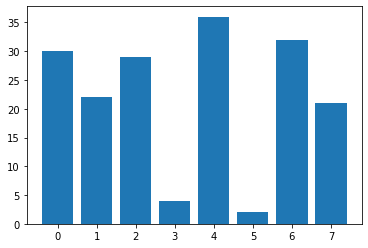

In [87]:
# Perform Subdistrict level clustering
bkk_sub_cluster_cnt = 8
subdistrict_kmeans = run_clustering(bkk_sub_grouped, bkk_sub_cluster_cnt, target='Subdistrict', random_state=31)

In [88]:
# add clustering labels
if 'Cluster Labels' in subdistrict_venues_sorted.columns:  
  subdistrict_venues_sorted = subdistrict_venues_sorted.drop('Cluster Labels', axis=1)

subdistrict_venues_sorted.insert(0, 'Cluster Labels', subdistrict_kmeans.labels_)

df_sub_merged = df_bkk_sub
df_sub_merged.set_index('Subdistrict')
# merge bkk_grouped with bkk data (df) to add latitude/longitude for each neighborhood
df_sub_merged.set_index('Subdistrict').head()
df_sub_merged = df_sub_merged.join(subdistrict_venues_sorted.set_index('Subdistrict'), on='Subdistrict') 
df_sub_merged['Cluster Labels'] = df_sub_merged['Cluster Labels'].replace(np.nan, -1)
df_sub_merged['Cluster Labels'] = df_sub_merged['Cluster Labels'].astype(int)
df_sub_merged.head(3) # check the last columns!

,Subdistrict,isSeat,Latitude,Longitude,Venue Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Phra Borom Maha Ratchawang, Phra Nakhon",0,13.75532,100.49498,2.234317,0,Nightlife,Culture,Café,Noodle House,Convenience Store,Asian Restaurant,Dessert Shop,Restaurant,Western Restaurant,Accomodation
1,"Wang Burapha Phirom, Phra Nakhon",0,13.74512,100.49935,0.777199,4,Café,Restaurant,Household,Asian Restaurant,Noodle House,Western Restaurant,Stores,Dessert Shop,Activities,Chinese Restaurant
2,"Wat Ratchabophit, Phra Nakhon",0,13.75047,100.50029,1.141478,6,Restaurant,Noodle House,Café,Dessert Shop,Accomodation,Culture,Household,Western Restaurant,Activities,Asian Restaurant


In [89]:
# create map
subdistrict_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=13, tiles="Stamen Toner",)

# set color scheme for the clusters
x = np.arange(bkk_sub_cluster_cnt)
ys = [i + x + (i*x)**2 for i in range(bkk_sub_cluster_cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(df_sub_merged['Latitude'], 
                                  df_sub_merged['Longitude'], 
                                  df_sub_merged['Subdistrict'], 
                                  df_sub_merged['Cluster Labels'],
                                  df_sub_merged['Venue Count']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= (6 + 4 * count),
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(subdistrict_venue_clusters)

subdistrict_venue_clusters

In [93]:
show_clusters(df_sub_merged, bkk_sub_cluster_cnt, limit=6)




Cluster 1 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Phra Borom Maha Ratchawang, Phra Nakhon",Nightlife,Culture,Café,Noodle House,Convenience Store,Asian Restaurant,Dessert Shop,Restaurant,Western Restaurant,Accomodation
3,"Samran Rat, Phra Nakhon",Restaurant,Accomodation,Noodle House,Culture,Café,Dessert Shop,Household,Asian Restaurant,Infrastructure,Nightlife
4,"San Chaopho Suea, Phra Nakhon",Nightlife,Restaurant,Asian Restaurant,Noodle House,Café,Chinese Restaurant,Dessert Shop,Accomodation,Culture,Convenience Store
5,"Sao Chingcha, Phra Nakhon",Restaurant,Dessert Shop,Café,Noodle House,Asian Restaurant,Convenience Store,Culture,Household,Nightlife,Western Restaurant
6,"Bowon Niwet, Phra Nakhon",Nightlife,Accomodation,Restaurant,Asian Restaurant,Café,Western Restaurant,Household,Convenience Store,Dessert Shop,Activities
7,"Talat Yot, Phra Nakhon",Nightlife,Restaurant,Asian Restaurant,Accomodation,Café,Culture,Household,Noodle House,Western Restaurant,Dessert Shop
8,"Chana Songkhram, Phra Nakhon",Nightlife,Accomodation,Restaurant,Asian Restaurant,Café,Noodle House,Household,Culture,Western Restaurant,Activities
9,"Ban Phan Thom, Phra Nakhon",Accomodation,Nightlife,Asian Restaurant,Café,Culture,Restaurant,Household,Noodle House,Japanese Restaurant,Chinese Restaurant
11,"Wat Sam Phraya, Phra Nakhon",Accomodation,Nightlife,Restaurant,Asian Restaurant,Culture,Household,Noodle House,Japanese Restaurant,Café,Activities
25,"Bang Rak, Bang Rak",Accomodation,Restaurant,Chinese Restaurant,Café,Western Restaurant,Sport,Asian Restaurant,Nightlife,Household,BBQ Joint





Cluster 2 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,"Hua Mak, Bang Kapi",Convenience Store,Asian Restaurant,Sport,Western Restaurant,Culture,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange
49,"Khum Thong, Lat Krabang",Convenience Store,Household,Infrastructure,Culture,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Western Restaurant,Toy / Game Store
58,"Hiran Ruchi, Thon Buri",Convenience Store,Commercial,Stores,BBQ Joint,Seafood Restaurant,Dessert Shop,Culture,Household,Hotpot Restaurant,Football Stadium
67,"Bang Kapi, Huai Khwang",Convenience Store,Infrastructure,Household,Restaurant,Hotpot Restaurant,Football Stadium,Dessert Shop,Western Restaurant,Café,Stores
70,"Khlong San, Khlong San",Convenience Store,Sport,Noodle House,Commercial,Seafood Restaurant,Café,Infrastructure,Culture,Hotpot Restaurant,Football Stadium
77,"Bang Ramat, Taling Chan",Convenience Store,Café,Western Restaurant,Asian Restaurant,BBQ Joint,Activities,Chinese Restaurant,Commercial,Toy / Game Store,Culture
80,"Ban Chang Lo, Bangkok Noi",Convenience Store,Household,Restaurant,Chinese Restaurant,Stores,Sport,BBQ Joint,Noodle House,Café,Asian Restaurant
82,"Bang Khun Si, Bangkok Noi",Convenience Store,Household,Chinese Restaurant,Restaurant,BBQ Joint,Sport,Noodle House,Culture,Hotpot Restaurant,Football Stadium
85,"Samae Dam, Bang Khun Thian",Culture,Convenience Store,Household,Infrastructure,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Western Restaurant,Toy / Game Store
86,"Bang Wa, Phasi Charoen",Sport,Convenience Store,Asian Restaurant,Café,Restaurant,Western Restaurant,Currency Exchange,Household,Hotpot Restaurant,Football Stadium





Cluster 3 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Si Yaek Maha Nak, Dusit",Restaurant,Convenience Store,Infrastructure,Noodle House,Accomodation,Culture,Commercial,Household,Sport,Stores
27,"Anusawari, Bang Khen",Restaurant,Asian Restaurant,Convenience Store,Western Restaurant,Dessert Shop,Noodle House,Household,Chinese Restaurant,Outlet Store,Café
33,"Pathum Wan, Pathum Wan",Sport,Western Restaurant,Café,Nightlife,Infrastructure,Restaurant,Japanese Restaurant,Chinese Restaurant,BBQ Joint,Asian Restaurant
37,"Khlong Maha Nak, Pom Prap Sattru Phai",Convenience Store,Noodle House,Asian Restaurant,Culture,Restaurant,Japanese Restaurant,Household,Hotpot Restaurant,Dessert Shop,Western Restaurant
57,"Wat Kanlaya, Thon Buri",Infrastructure,Restaurant,Culture,Convenience Store,Western Restaurant,Household,Noodle House,Activities,Café,Seafood Restaurant
59,"Bang Yi Ruea, Thon Buri",Infrastructure,Noodle House,Asian Restaurant,Household,Dessert Shop,Restaurant,Japanese Restaurant,Hotpot Restaurant,Football Stadium,Currency Exchange
60,"Bukkhalo, Thon Buri",Convenience Store,Asian Restaurant,Restaurant,Noodle House,Household,Chinese Restaurant,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange
62,"Dao Khanong, Thon Buri",Infrastructure,Household,Stores,Sport,BBQ Joint,Dessert Shop,Convenience Store,Noodle House,Culture,Hotpot Restaurant
69,"Somdet Chao Phraya, Khlong San",Noodle House,Asian Restaurant,Convenience Store,Household,Activities,Chinese Restaurant,Dessert Shop,Café,Culture,Hotpot Restaurant
91,"Pak Khlong Phasi Charoen, Phasi Charoen",Restaurant,Noodle House,Café,Infrastructure,Asian Restaurant,Convenience Store,Japanese Restaurant,Household,Western Restaurant,Sport





Cluster 4 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"Lam Phak Chi, Nong Chok",Restaurant,Western Restaurant,Activities,Asian Restaurant,BBQ Joint,Café,Chinese Restaurant,Commercial,Japanese Restaurant,Convenience Store
21,"Lam Toiting, Nong Chok",Restaurant,Convenience Store,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture,Western Restaurant,Japanese Restaurant
46,"Khlong Sam Prawet, Lat Krabang",Restaurant,Convenience Store,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture,Western Restaurant,Japanese Restaurant
137,"Makkasan, Ratchathewi",Restaurant,Café,Convenience Store,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture,Western Restaurant





Cluster 5 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Wang Burapha Phirom, Phra Nakhon",Café,Restaurant,Household,Asian Restaurant,Noodle House,Western Restaurant,Stores,Dessert Shop,Activities,Chinese Restaurant
16,"Thanon Nakhon Chai Si, Dusit",Convenience Store,Café,Restaurant,Chinese Restaurant,Stores,Sport,Noodle House,Hotpot Restaurant,Football Stadium,Dessert Shop
23,"Si Lom, Bang Rak",Café,Japanese Restaurant,Restaurant,Western Restaurant,Accomodation,Asian Restaurant,Stores,BBQ Joint,Nightlife,Sport
24,"Suriyawong, Bang Rak",Café,Japanese Restaurant,Restaurant,Western Restaurant,Chinese Restaurant,Accomodation,Asian Restaurant,BBQ Joint,Nightlife,Household
41,"Phra Khanong Tai, Phra Khanong",Café,Western Restaurant,Convenience Store,Japanese Restaurant,Restaurant,Infrastructure,Culture,Nightlife,Household,BBQ Joint
47,"Lam Pla Thio, Lat Krabang",Household,Café,Convenience Store,Infrastructure,Stores,Restaurant,Western Restaurant,Chinese Restaurant,BBQ Joint,Japanese Restaurant
50,"Chong Nonsi, Yan Nawa",Stores,Restaurant,Sport,Café,Western Restaurant,Nightlife,Culture,Hotpot Restaurant,Football Stadium,Dessert Shop
51,"Bang Phongphang, Yan Nawa",Café,Culture,Sport,Restaurant,Western Restaurant,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange
55,"Sam Sen Nai, Phaya Thai",Restaurant,Café,Western Restaurant,Asian Restaurant,BBQ Joint,Activities,Chinese Restaurant,Commercial,Japanese Restaurant,Convenience Store
56,"Phaya Thai, Phaya Thai",Restaurant,Café,Japanese Restaurant,Household,Accomodation,Nightlife,Asian Restaurant,Seafood Restaurant,BBQ Joint,Dessert Shop





Cluster 6 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,"Khlong Sip, Nong Chok",Noodle House,Western Restaurant,Culture,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Convenience Store,Japanese Restaurant
164,"Sai Kong Din, Khlong Sam Wa",Noodle House,Tourist Information Center,Western Restaurant,Culture,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Convenience Store





Cluster 7 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Wat Ratchabophit, Phra Nakhon",Restaurant,Noodle House,Café,Dessert Shop,Accomodation,Culture,Household,Western Restaurant,Activities,Asian Restaurant
10,"Bang Khun Phrom, Phra Nakhon",Noodle House,Restaurant,Accomodation,Café,Asian Restaurant,Convenience Store,Infrastructure,Chinese Restaurant,Culture,Household
12,"Dusit, Dusit",Noodle House,Café,Convenience Store,Restaurant,Asian Restaurant,Chinese Restaurant,Dessert Shop,Household,Sport,Tailor Shop
13,"Wachiraphayaban, Dusit",Restaurant,Noodle House,Café,Accomodation,Culture,Household,Asian Restaurant,Convenience Store,Western Restaurant,Hotpot Restaurant
14,"Suan Chitlada, Dusit",Culture,Noodle House,Restaurant,Café,Convenience Store,Accomodation,Hotpot Restaurant,Infrastructure,Household,Sport
22,"Maha Phruettharam, Bang Rak",Noodle House,Accomodation,Restaurant,Chinese Restaurant,Convenience Store,Dessert Shop,Western Restaurant,Seafood Restaurant,Nightlife,Household
35,"Pom Prap, Pom Prap Sattru Phai",Noodle House,Chinese Restaurant,Café,Dessert Shop,Asian Restaurant,Seafood Restaurant,Nightlife,Restaurant,Household,Culture
36,"Wat Thep Sirin, Pom Prap Sattru Phai",Noodle House,Asian Restaurant,Convenience Store,Culture,Nightlife,Café,Chinese Restaurant,Japanese Restaurant,Household,Hotpot Restaurant
39,"Wat Sommanat, Pom Prap Sattru Phai",Noodle House,Western Restaurant,Chinese Restaurant,Café,Restaurant,Convenience Store,Asian Restaurant,Dessert Shop,Household,Kids Store
40,"Bang Chak, Phra Khanong",Restaurant,Noodle House,Chinese Restaurant,Western Restaurant,Culture,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange





Cluster 8 out of 8




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,"Nong Chok, Nong Chok",Western Restaurant,Chinese Restaurant,Restaurant,Asian Restaurant,BBQ Joint,Café,Activities,Commercial,Japanese Restaurant,Convenience Store
19,"Khu Fang Nuea, Nong Chok",Restaurant,Western Restaurant,Household,Asian Restaurant,Stores,Culture,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange
28,"Tha Raeng, Bang Khen",Household,Stores,Restaurant,Noodle House,Convenience Store,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture
29,"Khlong Chan, Bang Kapi",Restaurant,Noodle House,Western Restaurant,Sport,Infrastructure,Japanese Restaurant,Asian Restaurant,Activities,Café,Chinese Restaurant
45,"Khlong Song Ton Nun, Lat Krabang",Restaurant,Household,Nightlife,Western Restaurant,Culture,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Convenience Store
48,"Thap Yao, Lat Krabang",Restaurant,Infrastructure,Stores,Convenience Store,Household,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture
74,"Taling Chan, Taling Chan",Accomodation,Stores,Restaurant,Infrastructure,Asian Restaurant,BBQ Joint,Café,Chinese Restaurant,Activities,Japanese Restaurant
88,"Bang Chak, Phasi Charoen",Restaurant,Asian Restaurant,Western Restaurant,Nightlife,Activities,Sport,Convenience Store,Hotpot Restaurant,Football Stadium,Dessert Shop
94,"Nong Khang Phlu, Nong Khaem",Restaurant,Convenience Store,Household,Café,Hotpot Restaurant,Football Stadium,Dessert Shop,Currency Exchange,Culture,Western Restaurant
104,"Nawamin, Bueng Kum",Restaurant,Convenience Store,Stores,Noodle House,Hotpot Restaurant,Seafood Restaurant,Café,Household,Nightlife,Football Stadium


## Clustering with even less Categories

In [126]:
bkk_reduced_onehot = bkk_sub_onehot[['Subdistrict', 'Accomodation', 'Activities', 'Sport', 'Nightlife', 'Culture']]
bkk_reduced_onehot = bkk_reduced_onehot[bkk_reduced_onehot.sum(axis=1) != 0].reset_index(drop=True)
bkk_reduced_onehot.tail()

,Subdistrict,Accomodation,Activities,Sport,Nightlife,Culture
820,"Thung Khru, Thung Khru",0,0,1,0,0
821,"Bang Bon Nuea, Bang Bon",0,0,1,0,0
822,"Bang Bon Tai, Bang Bon",0,0,1,0,0
823,"Khlong Bang Phran, Bang Bon",0,0,0,1,0
824,"Khlong Bang Bon, Bang Bon",0,0,0,1,0


825 Venues, 6 Categories
131 Subdistricts


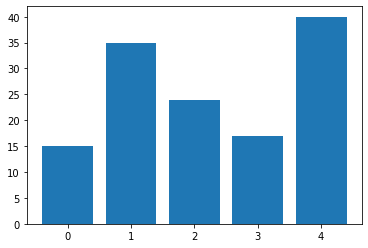

In [154]:
print(str(bkk_reduced_onehot.shape[0]) + " Venues, " + str(bkk_reduced_onehot.shape[1]) + " Categories")

bkk_reduced_sub_grouped = bkk_reduced_onehot.groupby('Subdistrict').mean().reset_index()
print(str(bkk_reduced_sub_grouped.shape[0]) + " Subdistricts")

subdistrict_reduced_venues_sorted = venue_extraction(bkk_reduced_sub_grouped, labl='Subdistrict', num_top_venues=4)
subdistrict_reduced_venues_sorted.head(3)

bkk_reduced_sub_cluster_cnt = 5
subdistrict_reduced_kmeans = run_clustering(bkk_reduced_sub_grouped, bkk_reduced_sub_cluster_cnt, target='Subdistrict', random_state=13)

In [155]:
# add clustering labels
if 'Cluster Labels' in subdistrict_reduced_venues_sorted.columns:  
  subdistrict_reduced_venues_sorted = subdistrict_reduced_venues_sorted.drop('Cluster Labels', axis=1)

subdistrict_reduced_venues_sorted.insert(0, 'Cluster Labels', subdistrict_reduced_kmeans.labels_)
df_reduced_sub_merged = df_bkk_sub
df_reduced_sub_merged.set_index('Subdistrict')
df_reduced_sub_merged = df_reduced_sub_merged.join(subdistrict_reduced_venues_sorted.set_index('Subdistrict'), on='Subdistrict') 
df_reduced_sub_merged['Cluster Labels'] = df_reduced_sub_merged['Cluster Labels'].replace(np.nan, -1)
df_reduced_sub_merged['Cluster Labels'] = df_reduced_sub_merged['Cluster Labels'].astype(int)

In [156]:
# create map
subdistrict_reduced_venue_clusters = folium.Map(location=[latitude, longitude], zoom_start=13, tiles="Stamen Toner",)

# set color scheme for the clusters
x = np.arange(bkk_reduced_sub_cluster_cnt)
ys = [i + x + (i*x)**2 for i in range(bkk_reduced_sub_cluster_cnt)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, count in zip(df_reduced_sub_merged['Latitude'], 
                                  df_reduced_sub_merged['Longitude'], 
                                  df_reduced_sub_merged['Subdistrict'], 
                                  df_reduced_sub_merged['Cluster Labels'],
                                  df_reduced_sub_merged['Venue Count']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius= (6 + 4 * count),
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(subdistrict_reduced_venue_clusters)

subdistrict_reduced_venue_clusters

In [157]:
show_clusters(df_reduced_sub_merged, bkk_reduced_sub_cluster_cnt, limit=6)




Cluster 1 out of 5




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
0,"Phra Borom Maha Ratchawang, Phra Nakhon",Nightlife,Culture,Accomodation,Sport
5,"Sao Chingcha, Phra Nakhon",Culture,Nightlife,Accomodation,Sport
14,"Suan Chitlada, Dusit",Culture,Sport,Accomodation,Nightlife
15,"Si Yaek Maha Nak, Dusit",Culture,Sport,Accomodation,Nightlife
36,"Wat Thep Sirin, Pom Prap Sattru Phai",Culture,Nightlife,Sport,Activities
37,"Khlong Maha Nak, Pom Prap Sattru Phai",Culture,Nightlife,Sport,Activities
41,"Phra Khanong Tai, Phra Khanong",Culture,Nightlife,Sport,Activities
50,"Chong Nonsi, Yan Nawa",Sport,Culture,Nightlife,Activities
51,"Bang Phongphang, Yan Nawa",Culture,Sport,Nightlife,Activities
57,"Wat Kanlaya, Thon Buri",Culture,Activities,Nightlife,Sport





Cluster 2 out of 5




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
4,"San Chaopho Suea, Phra Nakhon",Nightlife,Culture,Accomodation,Sport
6,"Bowon Niwet, Phra Nakhon",Nightlife,Accomodation,Culture,Activities
7,"Talat Yot, Phra Nakhon",Nightlife,Accomodation,Culture,Activities
35,"Pom Prap, Pom Prap Sattru Phai",Nightlife,Culture,Sport,Activities
44,"Lat Krabang, Lat Krabang",Nightlife,Culture,Sport,Activities
45,"Khlong Song Ton Nun, Lat Krabang",Nightlife,Culture,Sport,Activities
61,"Talat Phlu, Thon Buri",Nightlife,Sport,Culture,Activities
65,"Wat Tha Phra, Bangkok Yai",Nightlife,Culture,Sport,Activities
68,"Sam Sen Nok, Huai Khwang",Nightlife,Culture,Sport,Activities
71,"Bang Lamphu Lang, Khlong San",Nightlife,Accomodation,Sport,Culture





Cluster 3 out of 5




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
12,"Dusit, Dusit",Sport,Culture,Nightlife,Activities
16,"Thanon Nakhon Chai Si, Dusit",Sport,Culture,Nightlife,Activities
27,"Anusawari, Bang Khen",Sport,Culture,Nightlife,Activities
30,"Hua Mak, Bang Kapi",Sport,Culture,Nightlife,Activities
33,"Pathum Wan, Pathum Wan",Sport,Nightlife,Culture,Activities
42,"Min Buri, Min Buri",Sport,Culture,Nightlife,Activities
62,"Dao Khanong, Thon Buri",Sport,Culture,Nightlife,Activities
70,"Khlong San, Khlong San",Sport,Culture,Nightlife,Activities
75,"Chimphli, Taling Chan",Sport,Culture,Nightlife,Activities
80,"Ban Chang Lo, Bangkok Noi",Sport,Culture,Nightlife,Activities





Cluster 4 out of 5




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
29,"Khlong Chan, Bang Kapi",Sport,Activities,Culture,Nightlife
67,"Bang Kapi, Huai Khwang",Activities,Culture,Nightlife,Sport
69,"Somdet Chao Phraya, Khlong San",Activities,Culture,Nightlife,Sport
81,"Bang Khun Non, Bangkok Noi",Activities,Culture,Nightlife,Sport
88,"Bang Chak, Phasi Charoen",Nightlife,Sport,Activities,Culture
91,"Pak Khlong Phasi Charoen, Phasi Charoen",Sport,Activities,Culture,Nightlife
103,"Khlong Kum, Bueng Kum",Activities,Culture,Nightlife,Sport
111,"Lat Yao, Chatuchak",Activities,Sport,Accomodation,Culture
114,"Chomphon, Chatuchak",Activities,Culture,Nightlife,Sport
115,"Chatuchak, Chatuchak",Activities,Culture,Nightlife,Sport





Cluster 5 out of 5




,Subdistrict,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue
1,"Wang Burapha Phirom, Phra Nakhon",Culture,Nightlife,Sport,Activities
2,"Wat Ratchabophit, Phra Nakhon",Accomodation,Culture,Nightlife,Activities
3,"Samran Rat, Phra Nakhon",Accomodation,Culture,Nightlife,Activities
8,"Chana Songkhram, Phra Nakhon",Nightlife,Accomodation,Culture,Activities
9,"Ban Phan Thom, Phra Nakhon",Accomodation,Nightlife,Culture,Sport
10,"Bang Khun Phrom, Phra Nakhon",Accomodation,Culture,Nightlife,Sport
11,"Wat Sam Phraya, Phra Nakhon",Accomodation,Nightlife,Culture,Activities
13,"Wachiraphayaban, Dusit",Culture,Accomodation,Nightlife,Sport
22,"Maha Phruettharam, Bang Rak",Accomodation,Nightlife,Culture,Sport
23,"Si Lom, Bang Rak",Accomodation,Nightlife,Sport,Culture
